In [26]:
# Import packages
import xarray as xr
import numpy as np
import pandas as pd
import packaging
import matplotlib.pyplot as plt
import netCDF4
import math
import datetime
import seaborn as sns

# Define functions
def read_netcdf4(filename):
    '''Read in data from netcdf4'''
    # read in netcdf4 data to xarray
    storms_data = xr.open_dataset(filename)
    
    return storms_data


def tidy_CONUS_netcdf4(storms_data):
    '''assign headers, set datatypes, perform unit conversions if necessary'''

    # convert xarray dataarray to pandas dataframe
    storms_data = storms_data.RAINRATE.to_dataframe()
    
    # tidy data
    storms_data = storms_data.drop(['lat', 'lon'], axis=1)
    storms_data = storms_data.droplevel(['x', 'y'])
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    storms_data['datetime']= pd.to_datetime(storms_data['datetime'])
    storms_data = storms_data.rename(columns={"RAINRATE": "pr"})
    storms_data = storms_data.iloc[:,[1, 0]]
    # perform unit conversions if necessary
    # default units for netcdf4 are mm to 0.1 mm accuracy
    # storms_data.loc[ : , 'pr'] = storms_data.loc[ : , 'pr']

    return storms_data

def read_csv(filename):
    '''Read in data from csv, assign headers, set datatypes, perform unit conversions if necessary, and find time step for
       the dataset in minutes.'''
# read data from csv
    headers = ['datetime', 'pr']
    dtypes = {'col1': 'str', 'col2': 'float'}
    date_cols = ['datetime']
    storms_data = pd.read_csv(filename, dtype = dtypes, header=None, names = headers, skiprows = [0, 1], parse_dates = date_cols)
    
    # storms_data = pd.concat([storms_data, storms_new], ignore_index = True)
    
    # perform unit conversions
    storms_data.loc[ : , 'pr'] = storms_data.loc[ : , 'pr']
        
    return storms_data

def tidy_AORC_netcdf4(storms_data, city):
    '''Convert to dataframe, assign headers, set datatypes, perform unit conversions if necessary'''
    
    # tidy data
    storms_data = storms_data.sel(location = city).to_dataframe()

    # storms_data = storms_data['RAINRATE'].sel(location = city).to_dataframe()
    # rain = big_AORC['RAINRATE'].sel(location='Arlington')

    
    # make datetime its own column, not the index
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    storms_data['datetime'] = pd.to_datetime(storms_data['datetime'])
    storms_data = storms_data.rename(columns = {"RAINRATE": "pr"})
    
    # reorder columns for clarity
    storms_data = storms_data.iloc[:,[3, 4, 0]]
    
    # perform unit conversions if necessary
    # default units for AORC-CONUS netcdf4 precipitation are kg/m^2 ie: mm depth, so not conversions necessary
       
    
    return storms_data

def find_timestep(storms_data):
    '''Find time step of dataset in minutes by subtracting two datetimes'''
    # determine time step by subtracting one datetime from another
    TS = storms_data.iloc[1, 0] - storms_data.iloc[0, 0]
    # convert timedelta type to int type in minutes
    TS = TS.total_seconds() / 60
    return TS

def project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs, TS, subset):
    '''This is the meat of the process. It accepts model and historical data, finds Gumbel shape factors from each dataset, uses them to find
    the CDF value that corresponds with each precipitation intensity, calculates delta factors, and returns a time series of historical
    precipitation that has been projected into the future.'''
    
    # resample observed dataset to find hourly sums. This aligns the volumes from the hourly model data and the 5-min observed data
    resample = storms_obs.resample('60min', on = 'datetime').sum()
    # adjust index to include same number of entries as storms_obs
    resample = resample.loc[resample.index.repeat(60 / TS)].reset_index()
    # add resampled data to storms_obs
    storms_obs['pr_hourly'] = resample.pr
    
    
    # remove all dry times from datasets - this way only rainy periods are used to characterize the precipitation
    storms_modeled_past_no_0 = storms_modeled_past[storms_modeled_past['pr'] != 0]
    storms_modeled_future_no_0 = storms_modeled_future[storms_modeled_future['pr'] != 0]
    storms_obs_no_0 = storms_obs[storms_obs['pr_hourly'] != 0]
    
            
    # calculate statistics for each storm duration based on full rolling input of ~past~ data and find shape factors
    past_mean_pr = storms_modeled_past_no_0['pr'].mean()
    past_std_pr  = storms_modeled_past_no_0['pr'].std()
    euler_mascheroni_constant = 0.577215
    past_beta = past_std_pr * math.sqrt(6) / math.pi
    past_mu = past_mean_pr - past_beta * euler_mascheroni_constant

    # calculate statistics for each storm duration based on full rolling input of ~future~ data and find shape factors
    future_mean_pr = storms_modeled_future_no_0['pr'].mean()
    future_std_pr  = storms_modeled_future_no_0['pr'].std()
    future_beta = future_std_pr * math.sqrt(6) / math.pi
    future_mu = future_mean_pr - future_beta * euler_mascheroni_constant
        
    # calculate statistics for each storm duration based on full rolling input of ~observed~ data and find shape factors
    obs_mean_pr = storms_obs_no_0['pr_hourly'].mean()
    obs_std_pr  = storms_obs_no_0['pr_hourly'].std()
    obs_beta = obs_std_pr * math.sqrt(6) / math.pi
    obs_mu = obs_mean_pr - obs_beta * euler_mascheroni_constant
    
    
    # find the associated CDF value for each precipitation time step, solve for delta factors, and project the observed values into the future
    subset = subset.copy()
    subset.loc[:, 'location']     = 'Dover'
    subset.loc[:, 'obs_CDF']      = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - obs_mu) / obs_beta))
    subset.loc[:, 'past_CDF']     = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - past_mu) / past_beta))
    subset.loc[:, 'future_CDF']   = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - future_mu) / future_beta))
    subset.loc[:, 'past_pr']      = -1 * past_beta *   (np.log(-1 * np.log(subset.loc[:, 'obs_CDF']))) + past_mu
    subset.loc[:, 'future_pr']    = -1 * future_beta * (np.log(-1 * np.log(subset.loc[:, 'obs_CDF']))) + future_mu
    subset.loc[:, 'delta']        = subset.loc[:, 'future_pr'] / subset.loc[:, 'past_pr']
    subset.loc[:, 'projected_pr'] = subset.loc[:, 'delta'] * subset.loc[:, 'pr']

    
    # Add switch to fix edge case where model CDFs are negative for the smallest precipitation values
    # this is caused by the model under predicting precipitation for the study year
    subset.loc[subset.past_pr < 0, 'delta'] = 1
    subset.loc[subset.future_pr < 0, 'delta'] = 1
    subset.loc[subset.delta == 1, 'projected_pr'] = subset.pr

    return subset

In [2]:
def tidy_AORC_netcdf4(storms_data, city):
    '''Convert to dataframe, assign headers, set datatypes, perform unit conversions if necessary'''
    
    # tidy data
    storms_data = storms_data.sel(location = city).to_dataframe()

    # storms_data = storms_data['RAINRATE'].sel(location = city).to_dataframe()
    # rain = big_AORC['RAINRATE'].sel(location='Arlington')

    
    # make datetime its own column, not the index
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    storms_data['datetime'] = pd.to_datetime(storms_data['datetime'])
    storms_data = storms_data.rename(columns = {"RAINRATE": "pr"})
    
    # reorder columns for clarity
    storms_data = storms_data.iloc[:,[3, 4, 0]]
    
    # perform unit conversions if necessary
    # default units for AORC-CONUS netcdf4 precipitation are kg/m^2 ie: mm depth, so not conversions necessary
       
    
    return storms_data



city = 'Dover'
AORC_historical = read_netcdf4('files/AORC/AORC-1km-allyears.nc')
storms_obs = tidy_AORC_netcdf4(AORC_historical, city)




Project using AORC data as observed

In [3]:
city = 'Dover'


# Read netCDF4 data - climate model results
storms_modeled_past = read_netcdf4('files/CONUS/CONUS404-Historical-DoverOnly.nc')
storms_modeled_past = tidy_CONUS_netcdf4(storms_modeled_past)

def tidy_CONUS_netcdf4_2(storms_data, city):
    '''Convert to dataframe, assign headers, set data types, perform unit conversions if necessary'''
    
    # tidy data
    storms_data = storms_data['RAINRATE'].sel(location = city).to_dataframe()
    
    # make datetime its own column, not the index
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    storms_data['datetime'] = pd.to_datetime(storms_data['datetime'])
    storms_data = storms_data.rename(columns = {"RAINRATE": "pr"})
    
    # reorder columns for clarity
    storms_data = storms_data.iloc[:,[2, 4, 3]]
    
    # perform unit conversions if necessary
    # default units for CONUS404 netcdf4 are mm to 0.1 mm accuracy
    
    return storms_data

storms_modeled_future = read_netcdf4('files/CONUS/CONUS404-PGW-DoverOnly.nc')
storms_modeled_future = tidy_CONUS_netcdf4_2(storms_modeled_future, city)


# # Read full extent of observed data - tipping bucket rain gauge
# # Names of all data files
# files = ['files/dover_rain_gauge/DDFS.01-JAN-2005=01-JAN-2010.csv', 
#          'files/dover_rain_gauge/DDFS.01-JAN-2010=01-JAN-2015.csv',
#          'files/dover_rain_gauge/DDFS.01-JAN-2015=01-JAN-2020.csv',
#          'files/dover_rain_gauge/DDFS.01-JAN-2020=01-NOV-2023.csv'
#         ]

# # Read each file individually
# storms_obs0 = read_csv(files[0])
# storms_obs1 = read_csv(files[1])
# storms_obs2 = read_csv(files[2])
# storms_obs3 = read_csv(files[3])

# # Combine files into one dataframe
# storms_obs = pd.concat([storms_obs0, storms_obs1, storms_obs2, storms_obs3], ignore_index = True)

# # Replace all negative/error values with 0
# # The data from this site has some error values because the tipping bucket rain gauge doesn't work well with snow
# storms_obs.loc[storms_obs.pr < 0, 'pr'] = 0

# read AORC modeled data as historical
AORC_historical = read_netcdf4('files/AORC/AORC-1km-allyears.nc')
storms_obs = tidy_AORC_netcdf4(AORC_historical, city)


# Read a time series which is to be projected into the future
# data_2012 = read_csv('files/dover_rain_gauge/2012_historical.csv')

# Find the timestep of the observed data
# TS = find_timestep(storms_obs)
TS = 60

# Create TS to be projected 
year = 2012
storms_obs_year = storms_obs[storms_obs['datetime'].dt.year == year]

# Project time series and display results
# pd.options.mode.chained_assignment = None 
projected_by_intensity = 0
projected_by_intensity = project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs, TS, storms_obs_year)

projected_by_intensity.to_csv(f'files/output/Dover/dataframes/{city}_AORC_obs.csv', index = False)

# Set plot parameters ===================================================================================
# Establish colors to be used for plots
color0 = ('#1b9e77') # Past modeled
color1 = ('#d95f02') # Future modeled
color2 = ('#7570b3') # Past observed
color3 = ('#E7298A') # Future projected

# Set font for plots
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})

# Set figure size
plt.figure(figsize=(14, 5.6))

# Plot observed time series vs future projected time series ============================================
# Select data to be plotted
x1 = projected_by_intensity.datetime[:]
y1 = projected_by_intensity.pr[:]

x2 = x1
y2 = projected_by_intensity.projected_pr[:]

# Change plot labels and axes
plt.ylabel("Precipitation (mm/hr)", fontsize = 20)
plt.xlabel("Datetime", fontsize = 20)
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2012, 12, 31)])
# plt.ylim([0, 50])

# Construct plot
plt.plot(x2, y2, color = color3, label='Future Projected')
plt.plot(x1, y1, color = color2, label='Past Observed', alpha = 0.7)

plt.title(f"{city}_AORC_obs")
plt.legend(loc = 'upper right')

# Save plot to file
plt.savefig(f"files/output/Dover/plots/AORC_obs/{city}_TS.png")

# Clear figure so it doesn't redraw the data from older loops
plt.clf()


# tidy dataset so it won't plot delta values where the CONUS precip is negative ====================
projected_by_intensity.loc[projected_by_intensity.past_pr < 0, 'delta'] = None
projected_by_intensity.loc[projected_by_intensity.future_pr < 0, 'delta'] = None


# Create another dataset with duplicates removed and with values sorted ============================
projected_by_intensity_unique = projected_by_intensity.drop_duplicates()
projected_by_intensity_unique = projected_by_intensity.dropna()
projected_by_intensity_unique = projected_by_intensity_unique.sort_values(by = "pr")

# Plot CDFs ========================================================================================
# Select data to be plotted    
x1 = projected_by_intensity.pr[:]
y1 = projected_by_intensity.obs_CDF[:]

x2 = x1
y2 = projected_by_intensity.past_CDF[:]

x3 = x1
y3 = projected_by_intensity.future_CDF[:]

# Change plot labels and axes
# plt.xticks([])    
# plt.xlim([-1.2, 82])
# plt.ylim([0.18, 1.02])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("CDF", fontsize = 20)

# Construct plot
plt.plot(x2, y2, color = color0, marker='o', linestyle='', label='Past Modeled')
plt.plot(x3, y3, color = color1, marker='o', linestyle='', label='Future Modeled')
plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='Past Observed')

plt.title(f"{city}_AORC_obs")
plt.legend(loc = 'lower right')

# Save plot to file
plt.savefig(f"files/output/Dover/plots/AORC_obs/{city}_CDF.png")

# Clear figure
plt.clf()


# Plot delta values for each precipitation intensity =================================================


# Select data to be plotted
x1 = projected_by_intensity_unique.pr[:]
y1 = projected_by_intensity_unique.delta[:]

# Change plot labels and axes
# plt.xlim([-1.2, 84])
# plt.ylim([-0.1, 1.3])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("Delta", fontsize = 20)
plt.title(f"{city}_AORC_obs")

# Construct plot
plt.plot(x1, y1, color = color2, marker='', linestyle='-', label='')

# Save plot to file
plt.savefig(f"files/output/Dover/plots/AORC_obs/{city}_delta.png")

# Clear figure so it doesn't redraw the data from older loops
plt.clf()


# Plot delta values and CDFs together on one plot =====================================================
# Sort dataframe and remove duplicates to make it easy to plot deltas with a line plot
# Select delta data to be plotted 
x4 = projected_by_intensity_unique.pr[:]
y4 = projected_by_intensity_unique.delta[:]

# Select CDF data to be plotted    
x1 = projected_by_intensity.pr[:]
y1 = projected_by_intensity.obs_CDF[:]

x2 = x1
y2 = projected_by_intensity.past_CDF[:]

x3 = x1
y3 = projected_by_intensity.future_CDF[:]

# Change plot labels and axes
# plt.xticks([])    
plt.xlim([-0.2, max(x1) + 0.2])
if max(y4) > 2:
    plt.ylim([0, 2])
else:
    plt.ylim([0, max(y4) + .1])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("", fontsize = 20)

# Construct plot
plt.plot(x2, y2, color = color0, marker='o', linestyle=' ', label='Past Modeled CDF')
plt.plot(x3, y3, color = color1, marker='o', linestyle=' ', label='Future Modeled CDF')
plt.plot(x1, y1, color = color2, marker='o', linestyle=' ', label='Past Observed CDF')
plt.plot(x4, y4, color = color3, marker=' ', linestyle='-', label='Delta')


plt.title(f"{city}_AORC_obs")
plt.legend(loc = 'lower right')

# Plot horizontal line at y = 1 to show that only one city projected smaller storms overall
plt.axhline(y = 1, color = 'black', linestyle = '--', label = '')

# Save plot to file
plt.savefig(f"files/output/Dover/plots/AORC_obs/{city}_CDF_delta.png")
    
if projected_by_intensity.delta.max() > 2.0:
    print("^^ Delta is quite high")
    
plt.clf()


<Figure size 1400x560 with 0 Axes>

Plot using historical as observed

In [24]:
city = 'Dover'


# Read netCDF4 data - climate model results
storms_modeled_past = read_netcdf4('files/CONUS/CONUS404-Historical-DoverOnly.nc')
storms_modeled_past = tidy_CONUS_netcdf4(storms_modeled_past)

def tidy_CONUS_netcdf4_2(storms_data, city):
    '''Convert to dataframe, assign headers, set data types, perform unit conversions if necessary'''
    
    # tidy data
    storms_data = storms_data['RAINRATE'].sel(location = city).to_dataframe()
    
    # make datetime its own column, not the index
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    storms_data['datetime'] = pd.to_datetime(storms_data['datetime'])
    storms_data = storms_data.rename(columns = {"RAINRATE": "pr"})
    
    # reorder columns for clarity
    storms_data = storms_data.iloc[:,[2, 4, 3]]
    
    # perform unit conversions if necessary
    # default units for CONUS404 netcdf4 are mm to 0.1 mm accuracy
    
    return storms_data

storms_modeled_future = read_netcdf4('files/CONUS/CONUS404-PGW-DoverOnly.nc')
storms_modeled_future = tidy_CONUS_netcdf4_2(storms_modeled_future, city)


# Read full extent of observed data - tipping bucket rain gauge
# Names of all data files
files = ['files/dover_rain_gauge/DDFS.01-JAN-2005=01-JAN-2010.csv', 
         'files/dover_rain_gauge/DDFS.01-JAN-2010=01-JAN-2015.csv',
         'files/dover_rain_gauge/DDFS.01-JAN-2015=01-JAN-2020.csv',
         'files/dover_rain_gauge/DDFS.01-JAN-2020=01-NOV-2023.csv'
        ]

# Read each file individually
storms_obs0 = read_csv(files[0])
storms_obs1 = read_csv(files[1])
storms_obs2 = read_csv(files[2])
storms_obs3 = read_csv(files[3])

# Combine files into one dataframe
storms_obs = pd.concat([storms_obs0, storms_obs1, storms_obs2, storms_obs3], ignore_index = True)

# Replace all negative/error values with 0
# The data from this site has some error values because the tipping bucket rain gauge doesn't work well with snow
storms_obs.loc[storms_obs.pr < 0, 'pr'] = 0

# Read a time series which is to be projected into the future
data_2012 = read_csv('files/dover_rain_gauge/2012_historical.csv')

# Find the timestep of the observed data
TS = find_timestep(storms_obs)

# Project time series and display results
# pd.options.mode.chained_assignment = None 
projected_by_intensity = 0
projected_by_intensity = project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs, TS, data_2012)

projected_by_intensity.to_csv(f'files/output/Dover/dataframes/{city}_Historical_obs.csv', index = False)

# Set plot parameters ===================================================================================
# Establish colors to be used for plots
color0 = ('#1b9e77') # Past modeled
color1 = ('#d95f02') # Future modeled
color2 = ('#7570b3') # Past observed
color3 = ('#E7298A') # Future projected

# Set font for plots
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})

# Set figure size
plt.figure(figsize=(14, 5.6))

# Plot observed time series vs future projected time series ============================================
# Select data to be plotted
x1 = projected_by_intensity.datetime[:]
y1 = projected_by_intensity.pr[:]

x2 = x1
y2 = projected_by_intensity.projected_pr[:]

# Change plot labels and axes
plt.ylabel("Precipitation (mm/hr)", fontsize = 20)
plt.xlabel("Datetime", fontsize = 20)
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2012, 12, 31)])
# plt.ylim([0, 50])

# Construct plot
plt.plot(x2, y2, color = color3, label='Future Projected')
plt.plot(x1, y1, color = color2, label='Past Observed', alpha = 0.7)

plt.title(f"{city}_Historical_obs")
plt.legend(loc = 'upper right')

# Save plot to file
plt.savefig(f"files/output/Dover/plots/Historical_obs/{city}_TS.png")

# Clear figure so it doesn't redraw the data from older loops
plt.clf()


# tidy dataset so it won't plot delta values where the CONUS precip is negative ====================
projected_by_intensity.loc[projected_by_intensity.past_pr < 0, 'delta'] = None
projected_by_intensity.loc[projected_by_intensity.future_pr < 0, 'delta'] = None


# Create another dataset with duplicates removed and with values sorted ============================
projected_by_intensity_unique = projected_by_intensity.drop_duplicates()
projected_by_intensity_unique = projected_by_intensity.dropna()
projected_by_intensity_unique = projected_by_intensity_unique.sort_values(by = "pr")

# Plot CDFs ========================================================================================
# Select data to be plotted    
x1 = projected_by_intensity.pr[:]
y1 = projected_by_intensity.obs_CDF[:]

x2 = x1
y2 = projected_by_intensity.past_CDF[:]

x3 = x1
y3 = projected_by_intensity.future_CDF[:]

# Change plot labels and axes
# plt.xticks([])    
# plt.xlim([-1.2, 82])
# plt.ylim([0.18, 1.02])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("CDF", fontsize = 20)

# Construct plot
plt.plot(x2, y2, color = color0, marker='o', linestyle='', label='Past Modeled')
plt.plot(x3, y3, color = color1, marker='o', linestyle='', label='Future Modeled')
plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='Past Observed')

plt.title(f"{city}_Historical_obs")
plt.legend(loc = 'lower right')

# Save plot to file
plt.savefig(f"files/output/Dover/plots/Historical_obs/{city}_CDF.png")

# Clear figure
plt.clf()


# Plot delta values for each precipitation intensity =================================================


# Select data to be plotted
x1 = projected_by_intensity_unique.pr[:]
y1 = projected_by_intensity_unique.delta[:]

# Change plot labels and axes
# plt.xlim([-1.2, 84])
# plt.ylim([-0.1, 1.3])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("Delta", fontsize = 20)
plt.title(f"{city}_Historical_obs")

# Construct plot
plt.plot(x1, y1, color = color2, marker='', linestyle='-', label='')

# Save plot to file
plt.savefig(f"files/output/Dover/plots/Historical_obs/{city}_delta.png")

# Clear figure so it doesn't redraw the data from older loops
plt.clf()


# Plot delta values and CDFs together on one plot =====================================================
# Sort dataframe and remove duplicates to make it easy to plot deltas with a line plot
# Select delta data to be plotted 
x4 = projected_by_intensity_unique.pr[:]
y4 = projected_by_intensity_unique.delta[:]

# Select CDF data to be plotted    
x1 = projected_by_intensity.pr[:]
y1 = projected_by_intensity.obs_CDF[:]

x2 = x1
y2 = projected_by_intensity.past_CDF[:]

x3 = x1
y3 = projected_by_intensity.future_CDF[:]

# Change plot labels and axes
# plt.xticks([])    
plt.xlim([-0.2, max(x1) + 0.2])
if max(y4) > 2:
    plt.ylim([0, 2])
else:
    plt.ylim([0, max(y4) + .1])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("", fontsize = 20)

# Construct plot
plt.plot(x2, y2, color = color0, marker='o', linestyle=' ', label='Past Modeled CDF')
plt.plot(x3, y3, color = color1, marker='o', linestyle=' ', label='Future Modeled CDF')
plt.plot(x1, y1, color = color2, marker='o', linestyle=' ', label='Past Observed CDF')
plt.plot(x4, y4, color = color3, marker=' ', linestyle='-', label='Delta')


plt.title(f"{city}_Historical_obs")
plt.legend(loc = 'lower right')

# Plot horizontal line at y = 1 to show that only one city projected smaller storms overall
plt.axhline(y = 1, color = 'black', linestyle = '--', label = '')

# Save plot to file
plt.savefig(f"files/output/Dover/plots/Historical_obs/{city}_CDF_delta.png")
    
if projected_by_intensity.delta.max() > 2.0:
    print("^^ Delta is quite high")
    
plt.clf()


<Figure size 1400x560 with 0 Axes>

In [54]:
# Establish colors to be used for plots
color0 = ('#1b9e77') # Past modeled
color1 = ('#d95f02') # Future modeled
color2 = ('#7570b3') # Past observed
color3 = ('#E7298A') # Future projected

# Set font size for plots
plt.rcParams.update({'font.size': 16})

<function matplotlib.pyplot.show(close=None, block=None)>

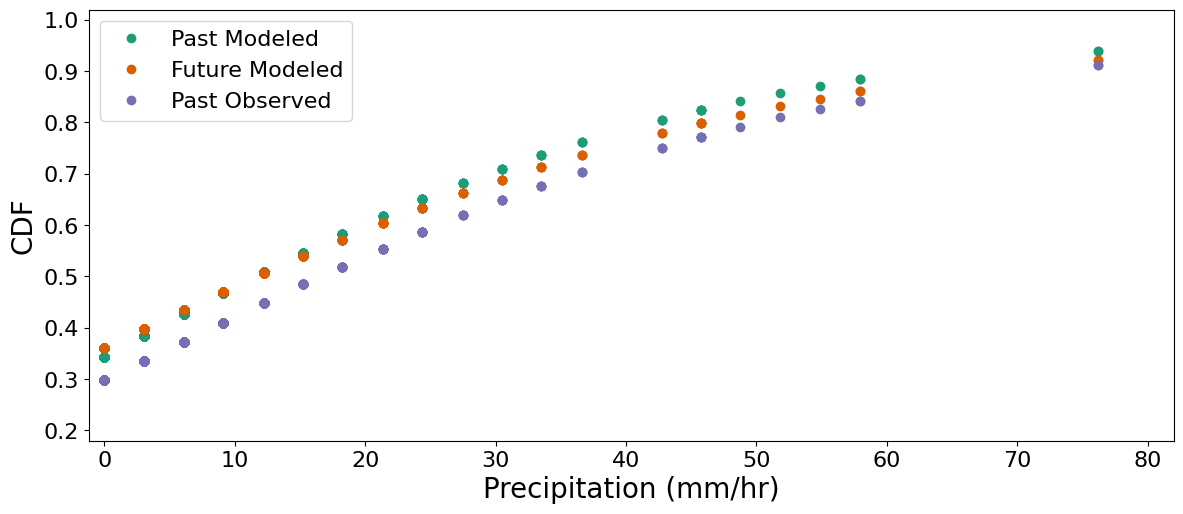

In [55]:
# Plot CDF values based on past & future modeled data and observed data
plt.figure(figsize=(14, 5.6))

x1 = projected_by_intensity.pr[:] * 12
y1 = projected_by_intensity.obs_CDF[:]

x2 = x1
y2 = projected_by_intensity.past_CDF[:]

x3 = x1
y3 = projected_by_intensity.future_CDF[:]

# plt.xticks([])    
plt.xlim([-1.2, 82])
plt.ylim([0.18, 1.02])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("CDF", fontsize = 20)

# print(colors[0])
plt.plot(x2, y2, color = color0, marker='o', linestyle='', label='Past Modeled')
plt.plot(x3, y3, color = color1, marker='o', linestyle='', label='Future Modeled')
plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='Past Observed')
plt.legend(['Past Modeled', 'Future Modeled', 'Past Observed'], loc = 'upper left')

plt.show

Compare AORC vs. Historical Precipitation

Read historical data from csv first. This takes a bit

In [ ]:
# Read full extent of observed data - tipping bucket rain gauge
# Names of all data files
files = ['files/dover_rain_gauge/DDFS.01-JAN-2005=01-JAN-2010.csv', 
         'files/dover_rain_gauge/DDFS.01-JAN-2010=01-JAN-2015.csv',
         'files/dover_rain_gauge/DDFS.01-JAN-2015=01-JAN-2020.csv',
         'files/dover_rain_gauge/DDFS.01-JAN-2020=01-NOV-2023.csv'
        ]

# Read each file individually
storms_obs0 = read_csv(files[0])
storms_obs1 = read_csv(files[1])
storms_obs2 = read_csv(files[2])
storms_obs3 = read_csv(files[3])

# Combine files into one dataframe
storms_obs_historical = pd.concat([storms_obs0, storms_obs1, storms_obs2, storms_obs3], ignore_index = True)

# Replace all negative/error values with 0
# The data from this site has some error values because the tipping bucket rain gauge doesn't work well with snow
storms_obs_historical.loc[storms_obs_historical.pr < 0, 'pr'] = 0

# resample observed dataset to find hourly sums. This aligns the volumes from the hourly model data and the 5-min observed data
storms_obs_historical = storms_obs_historical.resample('60min', on = 'datetime').sum()
# adjust index to include same number of entries as storms_obs
storms_obs_historical = storms_obs_historical.loc[storms_obs_historical.index.repeat(60 / TS)].reset_index()

storms_obs_historical

The minimum value 0.0 occurs 1857654 times.
The minimum value 0.0 occurs 148621 times.


,datetime,pr
0,2005-09-19 12:00:00,0.0
1,2005-09-19 13:00:00,0.0
2,2005-09-19 14:00:00,0.0
3,2005-09-19 15:00:00,0.0
4,2005-09-19 16:00:00,0.0
...,...,...
158788,2023-10-31 16:00:00,0.0
158789,2023-10-31 17:00:00,0.0
158790,2023-10-31 18:00:00,0.0
158791,2023-10-31 19:00:00,0.0


Read AORC data

In [50]:
city = 'Dover'
AORC_historical = read_netcdf4('files/AORC/AORC-1km-allyears.nc')
storms_obs_AORC = tidy_AORC_netcdf4(AORC_historical, city)

# Ensure the 'datetime' column is in datetime format
storms_obs_AORC['datetime'] = pd.to_datetime(storms_obs_AORC['datetime'])

# Set 'datetime' as the index
storms_obs_AORC.set_index('datetime', inplace=True)

# Set date range to match measured data and truncate dataset
start_date = '2005-09-19 12:00:00'
end_date = '2023-10-31 20:00:00'
storms_obs_AORC = storms_obs_AORC[start_date:end_date]
storms_obs_AORC 

,location,pr
datetime,,
2005-09-19 12:00:00,Dover,0.0
2005-09-19 13:00:00,Dover,0.0
2005-09-19 14:00:00,Dover,0.0
2005-09-19 15:00:00,Dover,0.0
2005-09-19 16:00:00,Dover,0.0
...,...,...
2023-10-31 16:00:00,Dover,0.0
2023-10-31 17:00:00,Dover,0.0
2023-10-31 18:00:00,Dover,0.0


Plot Violins

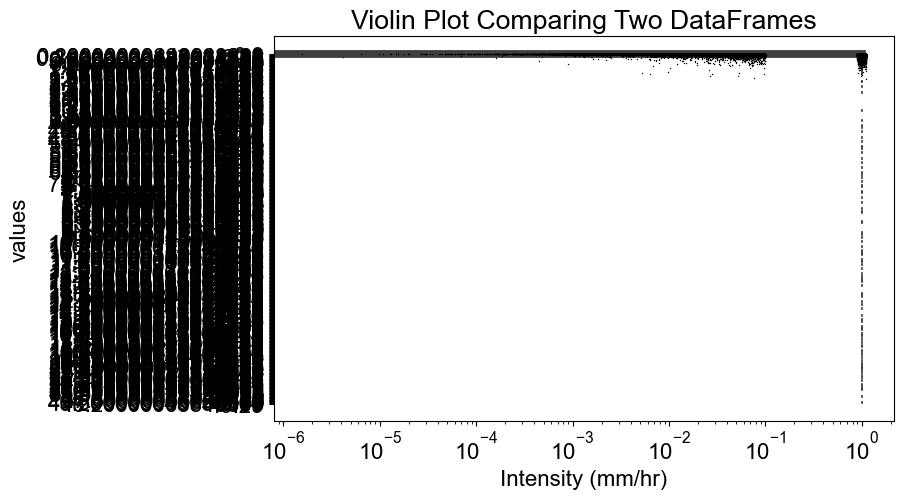

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example data (replace with your actual DataFrames)
# storms_obs_historical = pd.read_csv('historical_data.csv')
# storms_obs_AORC = pd.read_csv('AORC_data.csv')

# Get precipitation data
x0 = storms_obs_historical.loc[ :, 'pr' ]
x1 = storms_obs_AORC.loc[ :, 'pr' ]

# Add data series to one dataframe with correct group labels
obs_compare = pd.concat([
    pd.DataFrame( { 'values' : x0, 'group' : [ 'Measured' ] * len( x0 ) } ),
    pd.DataFrame( { 'values' : x1, 'group' : [ 'AORC' ] * len( x1 ) } )
])

# Create a violin plot
plt.figure( figsize=( 8, 5 ) )  # Optional: adjust figure size
sns.violinplot( x='group', y='values', data=obs_compare, orient='h' )

# Overlay jittered individual points
sns.stripplot( x='group', y='values', data=obs_compare, color='black', jitter=True, size=1 )

# Add labels and title
plt.title( 'Violin Plot Comparing Two DataFrames' )
plt.xlabel( 'Intensity (mm/hr)' )

# Change x-axis to log scale for better visualization
plt.xscale( 'log' )

# Show the plot
plt.show()


In [69]:
print(storms_obs_AORC.columns)

Index(['location', 'pr'], dtype='object')


In [75]:
# Get the minimum value
min_val = storms_obs_historical['pr'].min()

# Count how many times it occurs
count_min = (storms_obs_historical['pr'] == min_val).sum()

print(f"The minimum value {min_val} occurs {count_min} times.")

The minimum value -11988.0 occurs 8802 times.


In [77]:
print(len(storms_obs_historical))

158793


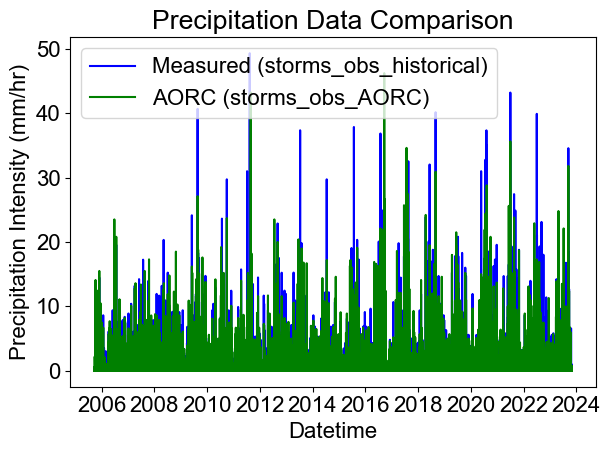

In [81]:
# Get precipitation data
y0 = storms_obs_historical.loc[:, 'pr']
y1 = storms_obs_AORC.loc[:, 'pr']

# Get datetime values for x-axis
x0 = storms_obs_AORC.index

# Create the plot
plt.plot(x0, y0, label='Measured (storms_obs_historical)', color='blue')
plt.plot(x0, y1, label='AORC (storms_obs_AORC)', color='green')

# Add labels and title
plt.title('Precipitation Data Comparison')
plt.xlabel('Datetime')
plt.ylabel('Precipitation Intensity (mm/hr)')

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


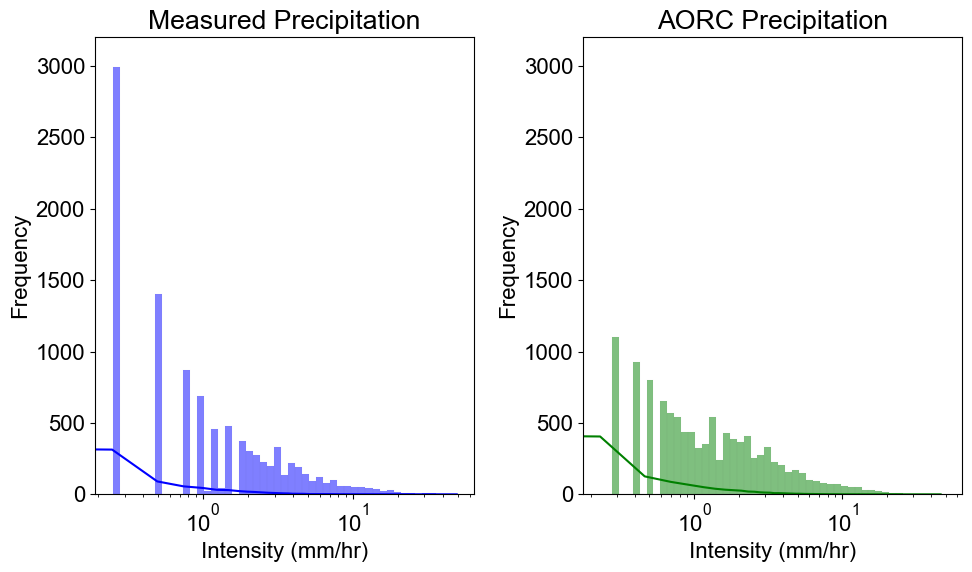

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get precipitation data
x0 = storms_obs_historical.loc[ :, 'pr' ]
x1 = storms_obs_AORC.loc[ :, 'pr' ]

# Create a figure with two subplots
plt.figure( figsize=( 10, 6 ) )

# Plot histogram for storms_obs_historical data

# Filter out zero or negative values
x0_nonzero = x0[x0 > 0]
bins = np.logspace(np.log10(x0_nonzero.min()), np.log10(x0_nonzero.max()), 50)

plt.subplot( 1, 2, 1 )  # 1 row, 2 columns, first subplot
sns.histplot( x0, bins=bins, kde=True, color='blue', label='Measured' )
plt.title( 'Measured Precipitation' )
plt.xlabel( 'Intensity (mm/hr)' )
plt.ylabel( 'Frequency' )
plt.xscale('log')
plt.ylim(0, 3200)

# Plot histogram for storms_obs_AORC data
plt.subplot( 1, 2, 2 )  # 1 row, 2 columns, second subplot
sns.histplot( x1, bins= bins, kde=True, color='green', label='AORC' )
plt.title( 'AORC Precipitation' )
plt.xlabel( 'Intensity (mm/hr)' )
plt.ylabel( 'Frequency' )
plt.xscale('log')
plt.ylim(0, 3200)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
